In [ ]:
# Colab cell 1 — Imports & notebook settings
# ---------------------------------------------------------
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

print("Libraries imported. Random seed set to", RANDOM_STATE)


Libraries imported. Random seed set to 42


In [ ]:
# Colab cell 2 — Load dataset & quick inspection

# ---------------------------------------------------------
df = pd.read_csv("covtype.csv")
print("Data shape:", df.shape)
display(df.head())
display(df.info())


Data shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

None

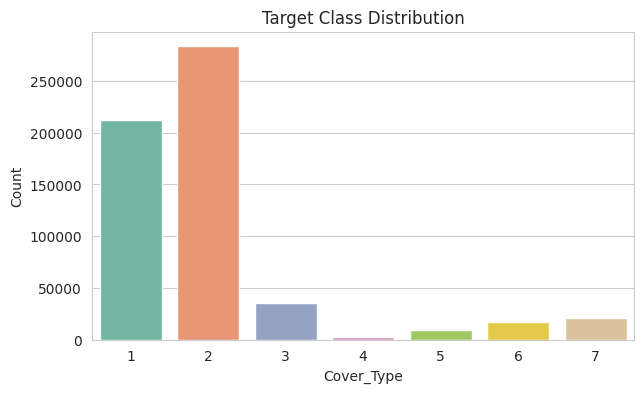

Normalized target distribution:
Cover_Type
1    0.364605
2    0.487599
3    0.061537
4    0.004728
5    0.016339
6    0.029891
7    0.035300
Name: proportion, dtype: float64


In [ ]:
# Colab cell 3 — Target distribution visualization
# ---------------------------------------------------------
plt.figure(figsize=(7,4))
sns.countplot(x=df['Cover_Type'], palette="Set2")
plt.title("Target Class Distribution")
plt.xlabel("Cover_Type")
plt.ylabel("Count")
plt.show()

# Print normalized class distribution
print("Normalized target distribution:")
print(df['Cover_Type'].value_counts(normalize=True).sort_index())


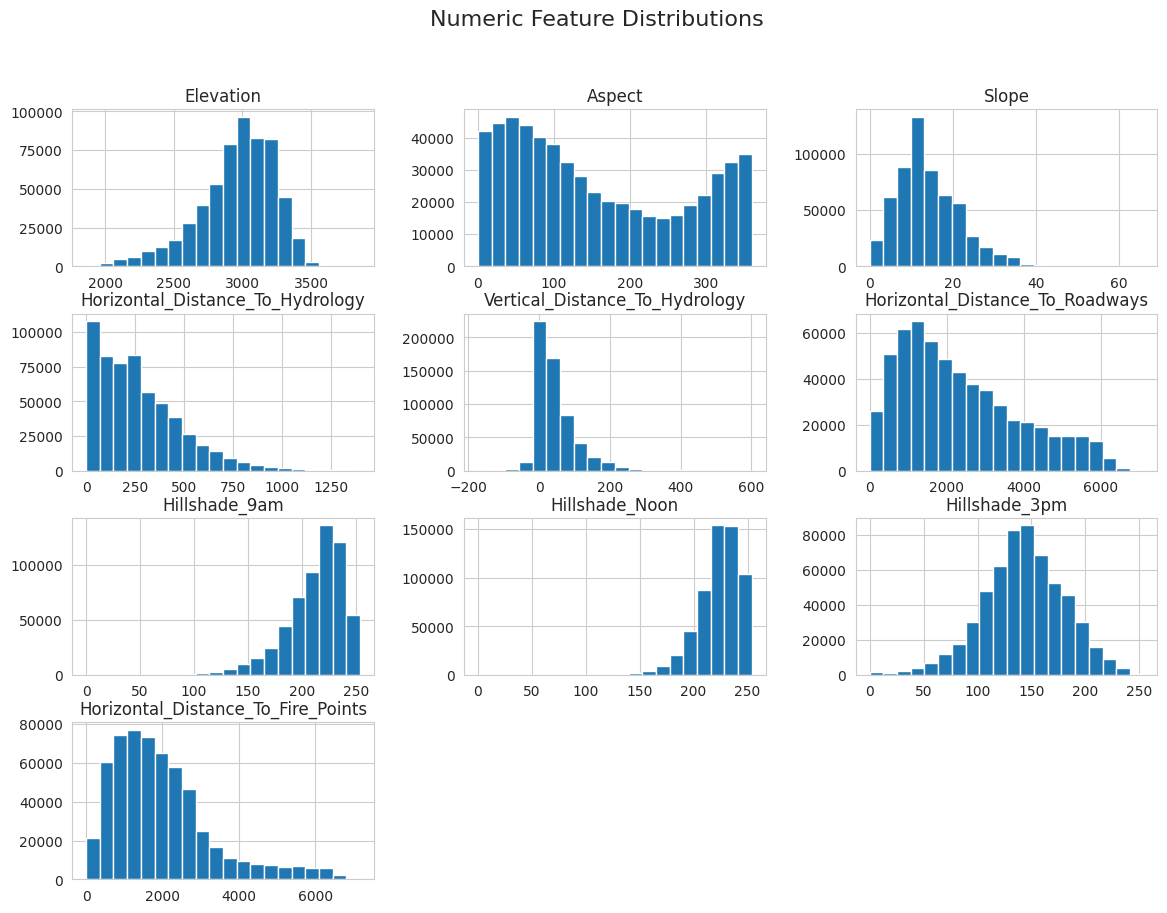

In [ ]:
# Colab cell 4 — Numeric features histograms
# ---------------------------------------------------------\
num_cols = df.columns[:10]
df[num_cols].hist(figsize=(14,10), bins=20)
plt.suptitle("Numeric Feature Distributions", fontsize=16)
plt.show()


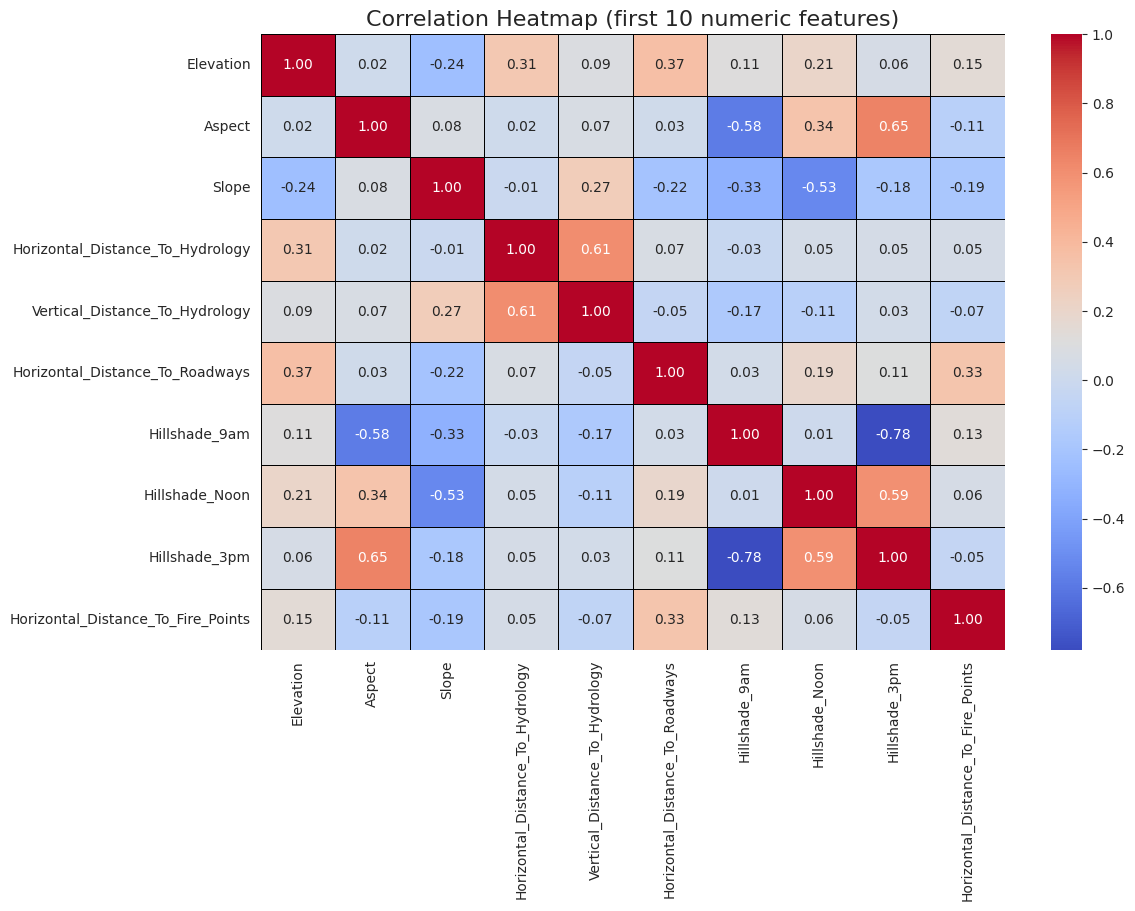

In [ ]:
# Colab cell 5 — Correlation heatmap (first 10 numeric cols)
# ---------------------------------------------------------
plt.figure(figsize=(12,8))
sns.heatmap(
    df[num_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="black",
    annot_kws={"size":10}
)
plt.title("Correlation Heatmap (first 10 numeric features)", fontsize=16)
plt.show()


In [ ]:
# Colab cell 6 — Train-test split & column partitioning
# ---------------------------------------------------------
# Separate features/target and create stratified train/test split.
X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Define which columns are numeric vs categorical based on your original layout.
num_cols = X.columns[:10]   # first 10 columns treated as numeric
cat_cols = X.columns[10:]   # remaining columns treated as categorical/one-hot style

print("Training samples:", X_train.shape[0], "Test samples:", X_test.shape[0])
print("Numeric cols (first 10):", list(num_cols))
print("Categorical cols (rest):", len(cat_cols), "columns")


Training samples: 464809 Test samples: 116203
Numeric cols (first 10): ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
Categorical cols (rest): 44 columns


In [ ]:
# Colab cell 7 — Preprocessing utilities (scaler fit on training only)
# ---------------------------------------------------------
# We'll create a Preprocessor class to encapsulate scaling and transformation.
class Preprocessor:
    def __init__(self, num_cols, cat_cols):
        self.num_cols = list(num_cols)
        self.cat_cols = list(cat_cols)
        self.scaler = StandardScaler()
        self.fitted = False

    def fit(self, X):
        # Fit scaler only on numeric columns of training data.
        self.scaler.fit(X[self.num_cols])
        self.fitted = True
        return self

    def transform(self, X):
        if not self.fitted:
            raise ValueError("Preprocessor must be fitted before transform().")
        X_num = self.scaler.transform(X[self.num_cols])
        X_cat = X[self.cat_cols].values  # assumed already numeric / one-hot encoded
        return np.hstack([X_num, X_cat])

    def fit_transform(self, X):
        return self.fit(X).transform(X)

# Initialize and fit preprocessor on training set
preprocessor = Preprocessor(num_cols=num_cols, cat_cols=cat_cols)
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

print("Transformed training shape:", X_train_p.shape)
print("Transformed test shape    :", X_test_p.shape)


Transformed training shape: (464809, 54)
Transformed test shape    : (116203, 54)


In [ ]:
# Colab cell 8 — Cross-validation evaluation function
# ---------------------------------------------------------
# This function performs Stratified K-Fold CV on numpy arrays and returns
# concatenated true/predicted labels across folds plus prints CV metrics.
def evaluate_model(model, X, y, name="Model", n_splits=5):
    """
    X: numpy array (samples x features)
    y: pandas Series (labels) OR numpy array
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    acc_list, f1_list, prec_list, rec_list = [], [], [], []
    y_true_all, y_pred_all = [], []

    # Ensure y is a pandas Series for .iloc indexing later
    y_series = y.reset_index(drop=True) if isinstance(y, pd.Series) else pd.Series(y)

    for tr_idx, val_idx in skf.split(X, y_series):
        X_tr, X_val = X[tr_idx], X[val_idx]
        y_tr, y_val = y_series.iloc[tr_idx], y_series.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        acc_list.append(accuracy_score(y_val, y_pred))
        f1_list.append(f1_score(y_val, y_pred, average="weighted"))
        prec_list.append(precision_score(y_val, y_pred, average="weighted"))
        rec_list.append(recall_score(y_val, y_pred, average="weighted"))

        y_true_all.extend(y_val.tolist())
        y_pred_all.extend(y_pred.tolist())

    print(f"\n{name} Cross-Validation Results (n_splits={n_splits}):")
    print(f"  Accuracy : {np.mean(acc_list):.4f} ± {np.std(acc_list):.4f}")
    print(f"  F1 Score : {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
    print(f"  Precision: {np.mean(prec_list):.4f} ± {np.std(prec_list):.4f}")
    print(f"  Recall   : {np.mean(rec_list):.4f} ± {np.std(rec_list):.4f}")

    return np.array(y_true_all), np.array(y_pred_all)



Logistic Regression Cross-Validation Results (n_splits=5):
  Accuracy : 0.7249 ± 0.0007
  F1 Score : 0.7152 ± 0.0007
  Precision: 0.7131 ± 0.0015
  Recall   : 0.7249 ± 0.0007


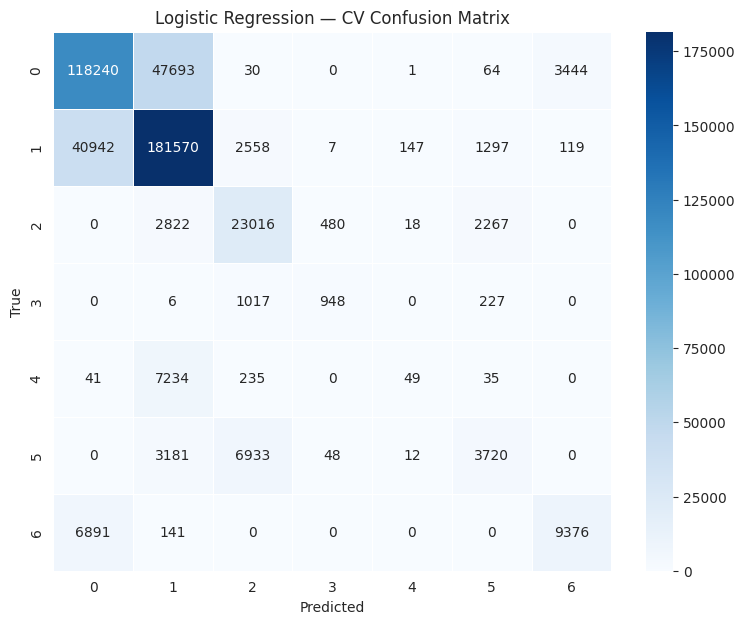

In [ ]:
# Colab cell 9 — Logistic Regression evaluation + confusion matrix
# ---------------------------------------------------------
# Configure and evaluate Logistic Regression (multinomial)
lr = LogisticRegression(multi_class="multinomial", max_iter=500, n_jobs=-1, random_state=RANDOM_STATE)

y_true_lr, y_pred_lr = evaluate_model(lr, X_train_p, y_train, name="Logistic Regression")

# Plot confusion matrix for CV concatenated predictions
cm = confusion_matrix(y_true_lr, y_pred_lr)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size":10}, linewidths=0.5)
plt.title("Logistic Regression — CV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



RBF SVM Cross-Validation Results (n_splits=5):
  Accuracy : 0.8191 ± 0.0007
  F1 Score : 0.8155 ± 0.0011
  Precision: 0.8182 ± 0.0004
  Recall   : 0.8191 ± 0.0007


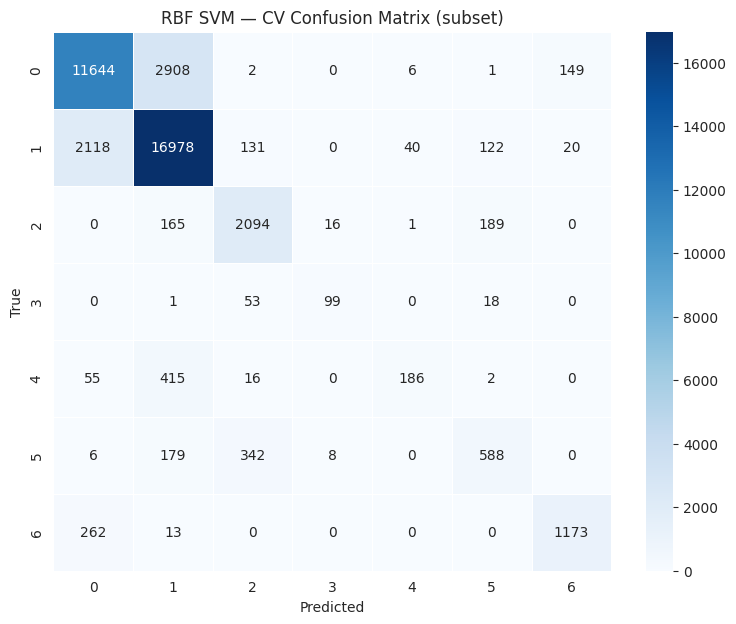

In [ ]:
# Colab cell 10 — RBF SVM evaluation (on a subset) + confusion matrix
# ---------------------------------------------------------
# SVM training is expensive on large datasets; use a reproducible random subset.
subset_size = 40000
rng = np.random.default_rng(RANDOM_STATE)
subset_idx = rng.choice(X_train_p.shape[0], size=subset_size, replace=False)

X_sub = X_train_p[subset_idx]
y_sub = y_train.reset_index(drop=True).iloc[subset_idx]

svm_rbf = SVC(kernel="rbf", C=10, gamma="scale", random_state=RANDOM_STATE)

y_true_svm_rbf, y_pred_svm_rbf = evaluate_model(svm_rbf, X_sub, y_sub, name="RBF SVM")

cm = confusion_matrix(y_true_svm_rbf, y_pred_svm_rbf)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size":10}, linewidths=0.5)
plt.title("RBF SVM — CV Confusion Matrix (subset)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# ---------------------------------------------------------
# LINEAR SVM (LinearSVC) — Cross-Validation evaluation
# ---------------------------------------------------------

from sklearn.svm import LinearSVC

# LinearSVC is faster on large datasets but does not provide predict_proba
svm_lin = LinearSVC(C=1, random_state=RANDOM_STATE)

# Evaluate using the existing evaluate_model() function
y_true_svm_lin, y_pred_svm_lin = evaluate_model(
    svm_lin,
    X_train_p,
    y_train,
    name="Linear SVM"
)

# Confusion Matrix for concatenated CV predictions
cm = confusion_matrix(y_true_svm_lin, y_pred_svm_lin)

plt.figure(figsize=(10,7))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    annot_kws={"size":12}, linewidths=0.5, linecolor="black"
)
plt.title("Linear SVM — CV Confusion Matrix", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()



ANN Cross-Validation Results (n_splits=5):
  Accuracy : 0.9274 ± 0.0025
  F1 Score : 0.9273 ± 0.0025
  Precision: 0.9277 ± 0.0023
  Recall   : 0.9274 ± 0.0025


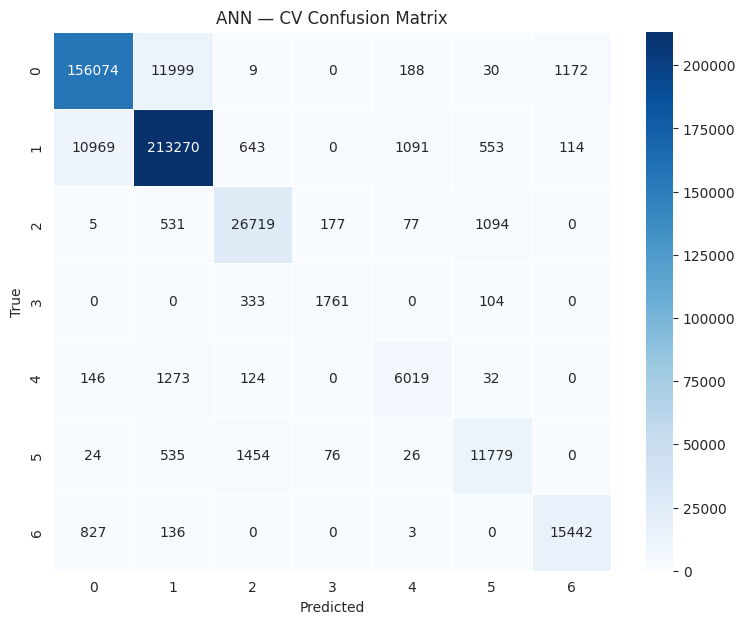

In [ ]:
# Colab cell 11 — ANN (MLPClassifier) evaluation + confusion matrix
# ---------------------------------------------------------
ann = MLPClassifier(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    solver='adam',
    batch_size=256,
    learning_rate_init=0.001,
    max_iter=30,             # consider increasing for better convergence
    random_state=RANDOM_STATE
)

y_true_ann, y_pred_ann = evaluate_model(ann, X_train_p, y_train, name="ANN")

cm = confusion_matrix(y_true_ann, y_pred_ann)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size":10}, linewidths=0.5)
plt.title("ANN — CV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


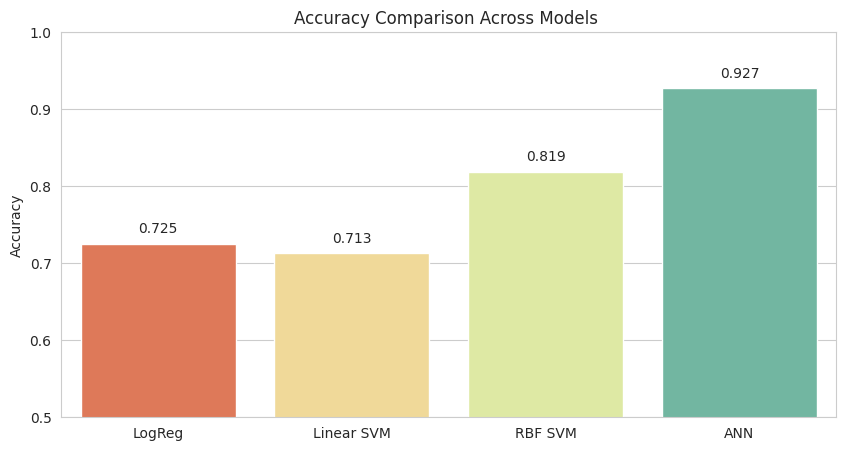

In [38]:
# Colab cell 12 — Accuracy comparison bar chart (example numbers)
# ---------------------------------------------------------
models = ["LogReg", "Linear SVM", "RBF SVM", "ANN"]
accuracies = [0.7249, 0.7128, 0.8190, 0.9274]  # keep your reported numbers

plt.figure(figsize=(10,5))
ax = sns.barplot(x=models, y=accuracies, palette="Spectral")
for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.01, f"{acc:.3f}", ha='center', va='bottom', fontsize=10)
plt.title("Accuracy Comparison Across Models ")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.show()

Fitting final ANN on full training data...
Test Accuracy: 0.9335645379207077

Classification Report:

              precision    recall  f1-score   support

           1       0.93      0.93      0.93     42368
           2       0.94      0.94      0.94     56661
           3       0.93      0.93      0.93      7151
           4       0.80      0.88      0.84       549
           5       0.82      0.83      0.82      1899
           6       0.89      0.85      0.87      3473
           7       0.95      0.94      0.95      4102

    accuracy                           0.93    116203
   macro avg       0.89      0.90      0.90    116203
weighted avg       0.93      0.93      0.93    116203



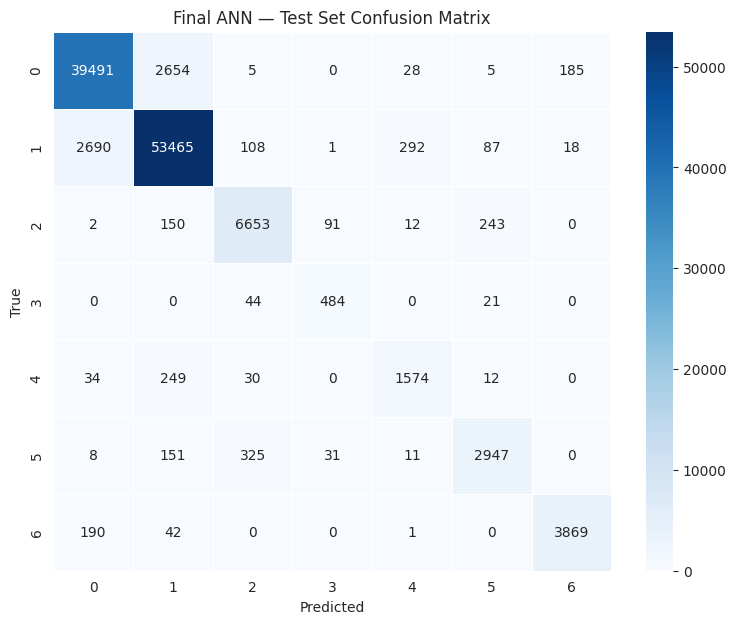

In [ ]:
# Colab cell 13 — Final: fit chosen model on full training set, evaluate on test set
# ---------------------------------------------------------
# Fit ANN (as in original code) on the entire training set then evaluate on X_test_p.
# Note: training an MLP on the full dataset may take time depending on resources.
final_model = MLPClassifier(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    solver='adam',
    batch_size=256,
    learning_rate_init=0.001,
    max_iter=30,
    random_state=RANDOM_STATE
)

print("Fitting final ANN on full training data...")
final_model.fit(X_train_p, y_train)

y_test_pred = final_model.predict(X_test_p)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))

# Confusion matrix on the held-out test set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size":10}, linewidths=0.5)
plt.title("Final ANN — Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [39]:
print("Calculating metrics...")

# Logistic Regression Metrics
lr_accuracy = accuracy_score(y_true_lr, y_pred_lr)
lr_f1 = f1_score(y_true_lr, y_pred_lr, average="weighted")
lr_precision = precision_score(y_true_lr, y_pred_lr, average="weighted")
lr_recall = recall_score(y_true_lr, y_pred_lr, average="weighted")

# Linear SVM Metrics
lin_svm_accuracy = accuracy_score(y_true_svm_lin, y_pred_svm_lin)
lin_svm_f1 = f1_score(y_true_svm_lin, y_pred_svm_lin, average="weighted")
lin_svm_precision = precision_score(y_true_svm_lin, y_pred_svm_lin, average="weighted")
lin_svm_recall = recall_score(y_true_svm_lin, y_pred_svm_lin, average="weighted")

# RBF SVM Metrics
rbf_svm_accuracy = accuracy_score(y_true_svm_rbf, y_pred_svm_rbf)
rbf_svm_f1 = f1_score(y_true_svm_rbf, y_pred_svm_rbf, average="weighted")
rbf_svm_precision = precision_score(y_true_svm_rbf, y_pred_svm_rbf, average="weighted")
rbf_svm_recall = recall_score(y_true_svm_rbf, y_pred_svm_rbf, average="weighted")

# ANN Metrics
ann_accuracy = accuracy_score(y_true_ann, y_pred_ann)
ann_f1 = f1_score(y_true_ann, y_pred_ann, average="weighted")
ann_precision = precision_score(y_true_ann, y_pred_ann, average="weighted")
ann_recall = recall_score(y_true_ann, y_pred_ann, average="weighted")

print("Metrics calculated for all models.")

Calculating metrics...
Metrics calculated for all models.


**Reasoning**:
Now that all the metrics have been calculated for each model, the next step is to consolidate them into a pandas DataFrame for structured storage and easier comparison, as requested in the main task.



In [40]:
model_names = ["Logistic Regression", "Linear SVM", "RBF SVM", "ANN"]
metrics_data = {
    "Accuracy": [lr_accuracy, lin_svm_accuracy, rbf_svm_accuracy, ann_accuracy],
    "F1-Score": [lr_f1, lin_svm_f1, rbf_svm_f1, ann_f1],
    "Precision": [lr_precision, lin_svm_precision, rbf_svm_precision, ann_precision],
    "Recall": [lr_recall, lin_svm_recall, rbf_svm_recall, ann_recall]
}

metrics_df = pd.DataFrame(metrics_data, index=model_names)
print("Model performance metrics DataFrame created:")
display(metrics_df)

Model performance metrics DataFrame created:


,Accuracy,F1-Score,Precision,Recall
Logistic Regression,0.724855,0.715179,0.713049,0.724855
Linear SVM,0.712850,0.697003,0.703585,0.712850
RBF SVM,0.819050,0.815592,0.818179,0.819050
ANN,0.927400,0.927318,0.927300,0.927400


**Reasoning**:
The next step is to visualize the performance metrics using a grouped bar chart, as requested in the main task. This will allow for easy comparison of Accuracy, F1-Score, Precision, and Recall across the different models.



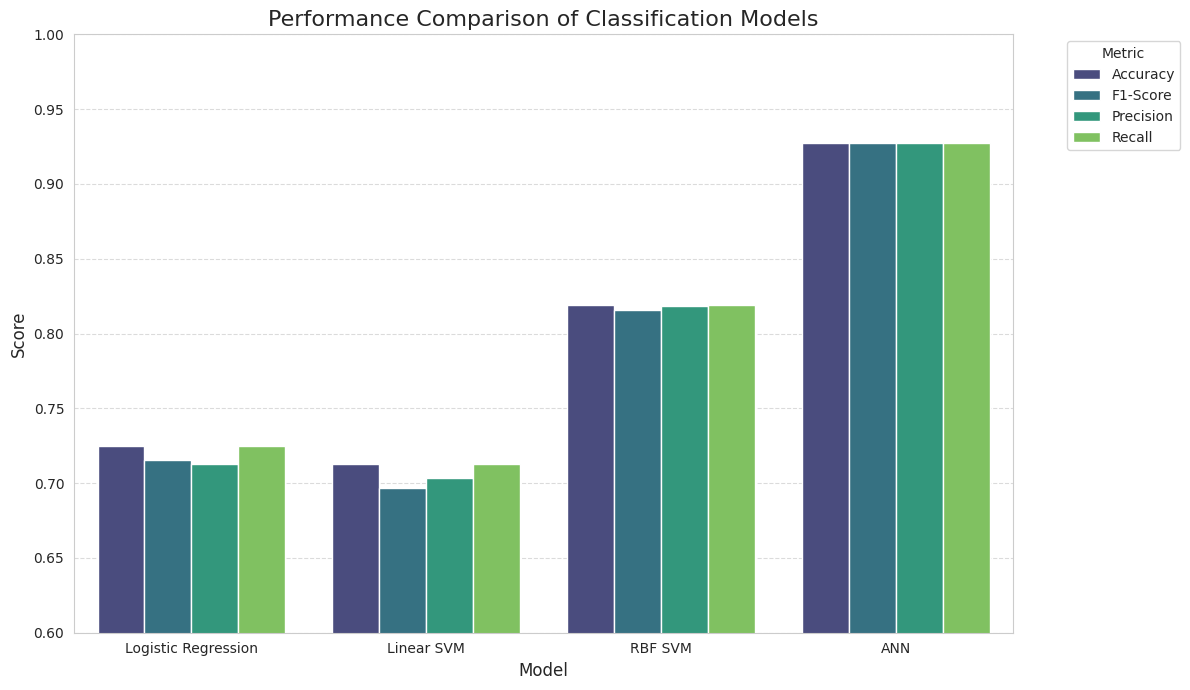

Grouped bar chart visualizing model performance metrics displayed.


In [41]:
metrics_df_melted = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='index', y='Score', hue='Metric', data=metrics_df_melted, palette='viridis')
plt.title('Performance Comparison of Classification Models', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.6, 1.0) # Adjust y-limit for better visualization of differences
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Grouped bar chart visualizing model performance metrics displayed.")

### Performance Comparison Summary

Based on the calculated metrics and the grouped bar chart, we can observe the following:

*   **ANN (Artificial Neural Network)** clearly outperforms all other models across all evaluated metrics (Accuracy, F1-Score, Precision, and Recall). It achieves the highest scores, indicating superior predictive capability and robustness in handling the multi-class classification problem.
*   **RBF SVM** comes in second, showing significantly better performance than Logistic Regression and Linear SVM. This suggests that the non-linear decision boundary capabilities of the RBF kernel are beneficial for this dataset.
*   **Logistic Regression** and **Linear SVM** perform similarly, with Logistic Regression having a slight edge over Linear SVM in most metrics. Both models achieve relatively lower scores compared to RBF SVM and ANN, suggesting that linear models might not be complex enough to capture the underlying patterns in the data effectively.

In summary, for this dataset, more complex models like ANN and RBF SVM are better suited for the classification task than simpler linear models.